## Seismic modelling with Devito

We can now start building our Devito model. The following draws heavily from the Devito `examples/sesimic/tutorials/01_modelling.ipynb` notebook. We will begin, as always with some imports.

In [1]:
import devito as dv
from examples.seismic import Model
import numpy as np
import matplotlib.pyplot as plt

As mentioned earlier, Devito and GemPy have slightly different grid implementations, so we need to tweak the Devito configuration slightly to make it map to the GemPy grid. We can now construct a Devito `Model`. This is a convenience object encapsulating the necessary parameters and components of an acoustic wave model, including additional damping layers around the perimeter (specified by `bcs="damp"`). For custom setups, see the `examples/userapi/04_boundary_conditions.ipynb`. Note that we are using a relatively large amount of damping layers here. This is to avoid our gathers becoming too messy, and ensure that reflections from horizons can be straightforwardly identified in the gathers.

In [2]:
# NBVAL_IGNORE_OUTPUT

shape = (101, 101, 201) # must be the same defined in the geological model

reshaped = np.load('3D_geological_model.npy') # importing the geological model
seis_model = Model(vp=reshaped, origin=(0., 0., -1000.), spacing=(20., 20., 10.), shape=shape, nbl=100, space_order=4, bcs="damp")

Operator `initdamp` ran in 0.05 s
Operator `pad_vp` ran in 0.04 s


Now we will set up the time axis for our model. Again, this is a convenience object, which we will use in setting up the source and recievers.

In [3]:
from examples.seismic import TimeAxis

t0 = 0.  # Simulation starts a t=0
tn = 1000.  # Simulation last 1 second (1000 ms)
dt = seis_model.critical_dt  # Time step from model grid spacing

time_range = TimeAxis(start=t0, stop=tn, step=dt)
print(time_range)

TimeAxis: start=0, stop=1001.48, step=1.811, num=554


We will position our source at a depth of 20m, and center it in all other axes.

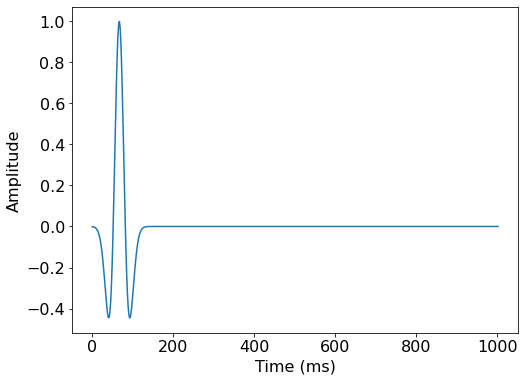

In [4]:
from examples.seismic import RickerSource

f0 = 0.015  # Source peak frequency is 15Hz (0.015 kHz)
src = RickerSource(name='src', grid=seis_model.grid, f0=f0,
                   npoint=1, time_range=time_range)

# First, position source centrally in all dimensions, then set depth
src.coordinates.data[:] = np.array(seis_model.domain_size) * .5 # x-axis location of the source
src.coordinates.data[0,1] = 0 # y-axis location of the source
src.coordinates.data[0, -1] = -20  # Depth is 20m

# We can plot the time signature to see the wavelet
src.show()

In [5]:
src.coordinates.data

Data([[1000.,    0.,  -20.]], dtype=float32)

We will also configure our recievers in a line along the x axis, centered in the y, also at a depth of 20m.

In [6]:
from examples.seismic import Receiver

# Create symbol for 101 receivers
rec = Receiver(name='rec', grid = seis_model.grid, npoint=101, time_range=time_range)

# Prescribe even spacing for receivers along the x-axis
rec.coordinates.data[:, 0] = np.linspace(0, seis_model.domain_size[0], num=101) # 101= number of geophones
rec.coordinates.data[:, 1] = 0.5*seis_model.domain_size[1] # y-axis location of the receiver line
rec.coordinates.data[:, -1] = -20.  # Depth is 20m

print(seis_model.domain_size[2])

2000.0


In Devito, equation parameters which vary in space only are represented using `Function` objects. If we also want them to vary over time, we must use a `TimeFunction`.

With this, we can define our partial differential equation.

In [7]:
# Define the wavefield with the size of the model and the time dimension
u = dv.TimeFunction(name="u", grid=seis_model.grid, time_order=2, space_order=4)

# We can now write the PDE
pde = seis_model.m * u.dt2 - u.laplace + seis_model.damp * u.dt

# The PDE representation is as on paper
pde

damp(x, y, z)*Derivative(u(t, x, y, z), t) - Derivative(u(t, x, y, z), (x, 2)) - Derivative(u(t, x, y, z), (y, 2)) - Derivative(u(t, x, y, z), (z, 2)) + Derivative(u(t, x, y, z), (t, 2))/vp(x, y, z)**2

Now create our update stencil:

In [8]:
# This discrete PDE can be solved in a time-marching way updating u(t+dt) from the previous time step
# Devito as a shortcut for u(t+dt) which is u.forward. We can then rewrite the PDE as 
# a time marching updating equation known as a stencil using customized SymPy functions

stencil = dv.Eq(u.forward, dv.solve(pde, u.forward))
stencil

Eq(u(t + dt, x, y, z), (-(-2.0*u(t, x, y, z)/dt**2 + u(t - dt, x, y, z)/dt**2)/vp(x, y, z)**2 + Derivative(u(t, x, y, z), (x, 2)) + Derivative(u(t, x, y, z), (y, 2)) + Derivative(u(t, x, y, z), (z, 2)) + damp(x, y, z)*u(t, x, y, z)/dt)/(damp(x, y, z)/dt + 1/(dt**2*vp(x, y, z)**2)))

Now we can set up our source and reciever terms to include in our `Operator`.

In [9]:
# Finally we define the source injection and receiver read function to generate the corresponding code
src_term = src.inject(field=u.forward, expr=src * dt**2 / seis_model.m)

# Create interpolation expression for receivers
rec_term = rec.interpolate(expr=u.forward)

Create our operator:

In [10]:
op = dv.Operator([stencil] + src_term + rec_term, subs=seis_model.spacing_map)

And run it.

In [11]:
# NBVAL_IGNORE_OUTPUT
op(time=time_range.num-1, dt=seis_model.critical_dt)

Operator `Kernel` ran in 25.17 s


PerformanceSummary([(PerfKey(name='section0', rank=None),
                     PerfEntry(time=25.152341000000018, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[])),
                    (PerfKey(name='section1', rank=None),
                     PerfEntry(time=0.00039100000000000294, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[])),
                    (PerfKey(name='section2', rank=None),
                     PerfEntry(time=0.008843000000000047, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[]))])

We can now plot our shot record using everyone's favourite colourmap. We can clearly see the reflected arrivals from the seabed, top shale, and sand reservoir.

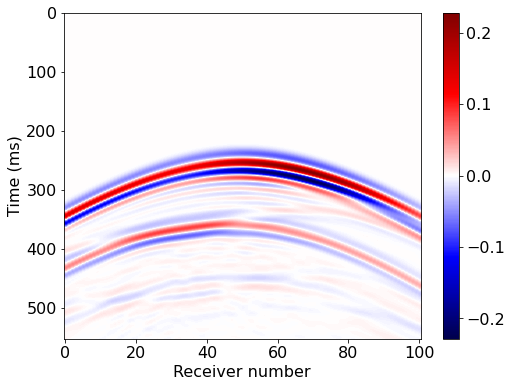

In [12]:
shot = rec.data[1:,:].copy()

plt.imshow(shot, cmap='seismic', aspect='auto')
plt.xlabel("Receiver number")
plt.ylabel("Time (ms)")
plt.colorbar()
plt.show()

(<matplotlib.image.AxesImage at 0x7f7f88d3da60>,
 <matplotlib.colorbar.Colorbar at 0x7f7f89a6e520>)

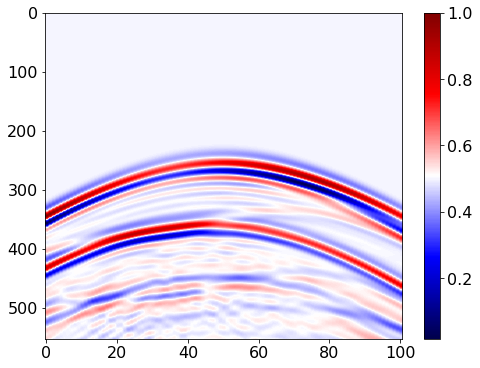

In [13]:
nt,nx = shot.shape
taxis = np.arange(nt)*seis_model.critical_dt
gain = np.tile((taxis**2.8)[:, np.newaxis], (1, nx)).T

shotgain = shot*gain.T
shotgain += shotgain.max()
shotgain /= shotgain.max()
plt.imshow(shotgain,aspect='auto',cmap='seismic'), plt.colorbar()

We can also display the frequency-wavenumber spectrum of the modeled shot.

In [14]:
dx = 20 # meters
dt = 0.001811 # seconds

def fk(data,dt,dx): 
    nt=data.shape[0]
    nx=data.shape[1]
    nt_fft=2*nt
    nx_fft=2*nx
    data_f=np.fft.fft(data,n=nt_fft,axis=0)
    data_fk=np.fft.fft(data_f,n=nx_fft,axis=1)
    FK=20*np.log10(np.fft.fftshift(np.abs(data_fk)))
    FK=FK[nt:,:]
    f = np.linspace(-0.5,0.5,nt_fft)/dt
    kx = np.linspace(-0.5,0.5,nt_fft)/dx
    return FK, f, kx

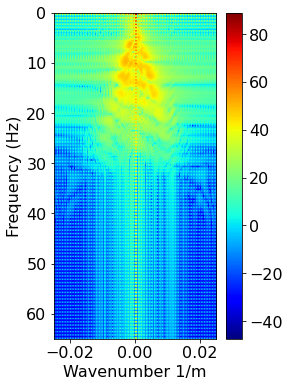

In [15]:
FK, f, kx = fk(shotgain,dt,dx)
plt.subplot(1,2,1)
plt.imshow(FK[:200],aspect='auto',cmap='jet',extent=[kx.min(), kx.max(), 65, 0])
plt.xlabel('Wavenumber 1/m')
plt.ylabel('Frequency (Hz)')
plt.colorbar()

To create our 3D seismic data, we must to simulate several sources and receivers lines as the following modeling function does:

In [18]:
def modeling(SX,SY,RL):
    rec.coordinates.data[:, 1] = RL # receiver line position in y-axis
    src.coordinates.data[0,1] = SY # source position in y-axis
    src.coordinates.data[0, 0] = SX # source position in x-axis
 
    # Finally we define the source injection and receiver read function to generate the corresponding code
    src_term = src.inject(field=u.forward, expr=src * dt**2 / seis_model.m)

    # Create interpolation expression for receivers
    rec_term = rec.interpolate(expr=u.forward)

    #Create our operator: 

    op = dv.Operator([stencil] + src_term + rec_term, subs=seis_model.spacing_map)

    op(time=time_range.num-1, dt=seis_model.critical_dt)

    # saving the data
    np.save('3D_data/SX'+str(SX)+'/RL_'+str(RL)+'_SP_'+ str(SY)+'.npy',rec.data)

In [ ]:
SY = np.arange(250,1750,100) # 15 shot points each 100 m in Y axis
RL = np.arange(250,1750,100) # 15 receiver lines each 100 m in Y axis
SX = np.arange(250,1600,150) # 10 sources lines each 150 m in X axis

# loop to 
for sx in SX:
    for rl in RL:
        for sy in SY:
            
            modeling(sx,sy,rl)

Operator `Kernel` ran in 25.11 s
Operator `Kernel` ran in 25.42 s
Operator `Kernel` ran in 25.25 s
Operator `Kernel` ran in 25.43 s
Operator `Kernel` ran in 24.77 s
Operator `Kernel` ran in 24.77 s
Operator `Kernel` ran in 24.76 s
Operator `Kernel` ran in 24.79 s
Operator `Kernel` ran in 24.76 s
Operator `Kernel` ran in 24.78 s
Operator `Kernel` ran in 24.76 s
Operator `Kernel` ran in 24.75 s
Operator `Kernel` ran in 24.79 s
Operator `Kernel` ran in 24.76 s
Operator `Kernel` ran in 24.82 s
Operator `Kernel` ran in 24.86 s
Operator `Kernel` ran in 24.86 s
Operator `Kernel` ran in 25.02 s
Operator `Kernel` ran in 24.90 s
Operator `Kernel` ran in 24.82 s
Operator `Kernel` ran in 24.84 s
Operator `Kernel` ran in 24.83 s
Operator `Kernel` ran in 24.85 s
Operator `Kernel` ran in 24.81 s
Operator `Kernel` ran in 24.87 s
Operator `Kernel` ran in 24.83 s
Operator `Kernel` ran in 24.86 s
Operator `Kernel` ran in 24.83 s
Operator `Kernel` ran in 24.84 s
Operator `Kernel` ran in 24.83 s
Operator `